<a href="https://colab.research.google.com/github/kfcav/Simple.ONA/blob/master/SimpleONA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Organizational Network Analysis (ONA)**
---

> Ken Cavanagh



**Intro:**

This notebook provides a walkthrough for conducting an ONA in its simplest form. By using it, you can get a better understanding of the informal networks of communication in your organizaion.

This code utilizes a survey to collect network data. The survey, like this notebook, is in its simplest form. There are many other ways to do network analysis, but they can gain complexity rather quickly. To get the most out of this notebook, create a survey with the questions in the workbook (stored in the github repo) and record the responses in the format shown in the response data tab. Then, run this code, block by block.




**Let's Begin:**

We will start by importing the necessary python packages and importing the data file that we will be working with.

In [ ]:
# Importing Packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Importing dataset into colab
# We will need to use the following code to import the dataset into this colab notebook
# After running this block, click choose files and load the Simple_ONA_Survey file
from google.colab import files

uploaded = files.upload()

Saving Simple_ONA_Survey.xlsx to Simple_ONA_Survey (3).xlsx


In [ ]:
# After uploading the file, we can see what name it has been saved with in colab
# Use pd.read_excel() to read the file by typing the name in quotations and assigning it to a variable

#survey data
survey = pd.read_excel('Simple_ONA_Survey (3).xlsx', sheet_name='Response_Data')
#and specifically read in the worksheet called "Raw Survey Data Output"

#questionnaire items
questions = pd.read_excel('Simple_ONA_Survey (3).xlsx', sheet_name='Questionnaire_Items')

#HRIS Data
hris = pd.read_excel('Simple_ONA_Survey (3).xlsx', sheet_name='HRIS_Data')

In [ ]:
#lets take a look at the first few rows of our survey data
survey.head()

,participant_email,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q1_8,Q1_9,Q1_10,Q1_11,Q1_12,Q1_13,Q1_14,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q2_8,Q2_9,Q2_10,Q2_11,Q2_12,Q2_13,Q2_14
0,Bob@thecompany.com,Joe@thecompany.com,Mike@thecompany.com,Ava@thecompany.com,Lucy@thecompany.com,Nancy@thecompany.com,Steve@thecompany.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nancy@thecompany.com,Joe@thecompany.com,Frank@thecompany.com,David@thecompany.com,Raj@thecompany.com,Bridget@thecompany.com,Lucas@thecompany.com,Bob@thecompany.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Steve@thecompany.com,Joe@thecompany.com,Bruno@thecompany.com,Alberto@thecompany.com,Nancy@thecompany.com,Raj@thecompany.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Joe@thecompany.com,Bob@thecompany.com,Nancy@thecompany.com,Steve@thecompany.com,Mike@thecompany.com,Frank@thecompany.com,Bruno@thecompany.com,Bella@thecompany.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mike@thecompany.com,Bob@thecompany.com,Bella@thecompany.com,Ava@thecompany.com,Lucy@thecompany.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#lets make sure our HRIS data loads in correctly
hris.head()

,email,Title,Department
0,Bruno@thecompany.com,Account Director,Account Management
1,Alberto@thecompany.com,Account Executive,Account Management
2,Ava@thecompany.com,Analyst,Finance
3,Joe@thecompany.com,CEO,Executive
4,Bob@thecompany.com,CFO,Executive


In [ ]:
# lets display the questions for reference
questions

,Q_Num,Question,Choices,Q_Type
0,Q1,Who is important to your work? List up to 14 p...,List up to 14 colleagues at the company,Network Question
1,Q2,Of those who are important to your work who d...,Checkbox for each colleague listed in question 1,Network Question


## **Manipulating Our Data**



Now that we have our data imported and ready to go, we can begin transforming into a suitable format for analysis.

In [ ]:
#First we will transpose our survey response data (turning rows into columns)
network_data=pd.wide_to_long(survey, stubnames=['Q1_','Q2_'], #questions we will put into a single column
                                      i='participant_email', #column we pivot on
                                      j='alter_id') #creating a new variable

#some of our participants didn't have as many as 14 people listed as important to their work 
#let's drop records where no one is listed as important
network_data=network_data[~pd.isna(network_data['Q1_'])]
network_data.reset_index(inplace=True) 

network_data.head(10) #let's take a look at the data

,participant_email,alter_id,Q1_,Q2_
0,Bob@thecompany.com,1,Joe@thecompany.com,NaN
1,Nancy@thecompany.com,1,Joe@thecompany.com,NaN
2,Steve@thecompany.com,1,Joe@thecompany.com,1.0
3,Joe@thecompany.com,1,Bob@thecompany.com,NaN
4,Mike@thecompany.com,1,Bob@thecompany.com,NaN
5,Ava@thecompany.com,1,Bob@thecompany.com,NaN
6,Lucy@thecompany.com,1,Bob@thecompany.com,NaN
7,Frank@thecompany.com,1,Nancy@thecompany.com,NaN
8,David@thecompany.com,1,Nancy@thecompany.com,NaN
9,Raj@thecompany.com,1,Nancy@thecompany.com,1.0


Our data has been transformed so that emails are in the rows and there is a 1.0 in the question column if a participant selected that person for Question 2.

**Ego and Alter**

Now we are going to create what is called an *Ego Network*. In an Ego Network, Ego is a single entity or node which is associated with an *Alter* which is the entity or node connected to that *Ego*.

We will rename participant email and Q1 to make this more clear. We will also rename Q2 to reflect what the question is asking (this is mostly done for readability).

In [ ]:
network_data.rename(columns={'participant_email':'ego',           
                                      'Q1_':'alter',                  
                                      'Q2_':'Greater access needed'},
                             inplace=True) 

network_data.drop(columns='alter_id', inplace=True) # We don't need this column anymore

network_data.sort_values(by='ego',inplace=True)     # Sorting participants to make things more clear

network_data.head(10)                               # Lets see what this looks like

,ego,alter,Greater access needed
43,Alberto@thecompany.com,Bella@thecompany.com,1.0
13,Alberto@thecompany.com,Steve@thecompany.com,NaN
28,Alberto@thecompany.com,Bruno@thecompany.com,NaN
66,Alberto@thecompany.com,David@thecompany.com,NaN
56,Alberto@thecompany.com,Bridget@thecompany.com,NaN
20,Ava@thecompany.com,Bella@thecompany.com,NaN
62,Ava@thecompany.com,David@thecompany.com,NaN
50,Ava@thecompany.com,Lucy@thecompany.com,NaN
35,Ava@thecompany.com,Mike@thecompany.com,1.0
5,Ava@thecompany.com,Bob@thecompany.com,NaN


### **Joining Our Datasets**

Here we will add the hris data to the network data to use later.

In [ ]:
ego_hris=hris.copy()                                    # First we need to copy the hris data

                                                                  # Next we will rename columns to match the network data
ego_hris.rename(columns={'email':'ego',
                                'Title':'ego_title', 
                                'Department':'ego_team'}, 
                                            inplace=True)

                                                                  # Now we can join the ego hris df to the network data
network_data=pd.merge(network_data,
                               ego_hris,
                               on='ego',
                               how='left')
                             

alter_hris=hris.copy()                                 # We will repeat this process for the alter

alter_hris.rename(columns={'email':'alter',
                                      'Title':'alter_title', 
                                      'Department':'alter_team'}, 
                             inplace=True)

network_data=pd.merge(network_data,
                               alter_hris,
                               on='alter',
                               how='left')

network_data.head()                                                 # Let's take a look at our data

,ego,alter,Greater access needed,ego_title,ego_team,alter_title,alter_team
0,Alberto@thecompany.com,Bella@thecompany.com,1.0,Account Executive,Account Management,Jr Account Executive,Account Management
1,Alberto@thecompany.com,Steve@thecompany.com,NaN,Account Executive,Account Management,CSO,Executive
2,Alberto@thecompany.com,Bruno@thecompany.com,NaN,Account Executive,Account Management,Account Director,Account Management
3,Alberto@thecompany.com,David@thecompany.com,NaN,Account Executive,Account Management,IT Support Specialist,Technology
4,Alberto@thecompany.com,Bridget@thecompany.com,NaN,Account Executive,Account Management,Developer,Technology


## **Cross-team Collaboration**

A common way to look at cross team collaboration is to use a block density chart. This represents the number of connections to other groups as a percentage of a group's all outgoing connections.

In [ ]:
# The crosstab method creates a frequency table
cross_team=pd.crosstab(index=network_data['ego_team'],
                               columns=network_data['alter_team'],
                               normalize='index')
# Multiply by 100 to get percentages
cross_team*100 

alter_team,Account Management,Executive,Finance,Technology
ego_team,,,,
Account Management,40.000000,20.000000,0.000000,40.000000
Executive,16.000000,40.000000,16.000000,28.000000
Finance,21.428571,21.428571,42.857143,14.285714
Technology,15.789474,26.315789,21.052632,36.842105


These results suggest that most teams collaborate internally (highest percentages are with themselves), which is expected. However, in an organization where collaboration is essential to success, we might want to make adjustments after seeing these results.

## **Visualizing the Network**

Now on to the fun stuff: Creating our network graph.

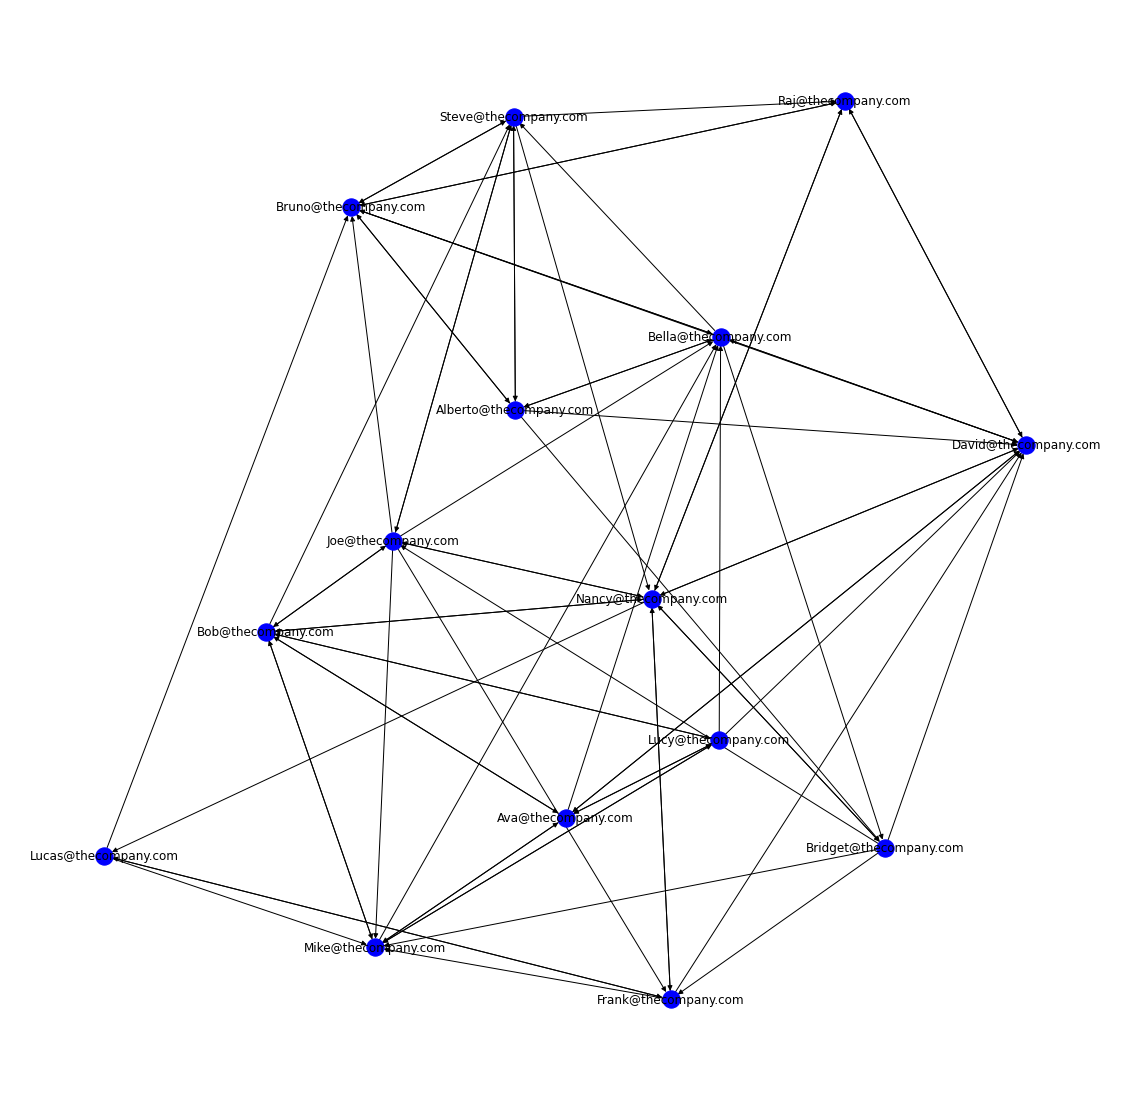

In [ ]:
# We will use the networkx library to do this

network_graph=nx.from_pandas_edgelist(network_data,              # This tells networkx that our dataframe can be read as a list of connections
                                      source='ego', 
                                      target='alter',
                                      create_using=nx.DiGraph()) # This tells networkx that connections can go both ways (people can both seek and be sought)
                                                                 

                            # We will also use matplotlib to display the graph

plt.figure(figsize=(20,20)) # Change the default plot size                                             
limits=plt.axis('off')      # Get rid of the axis
nx.draw_networkx(network_graph,
                 arrows=True,
                 node_color='b')

**Cool!**

We've created our first network graph. This shows us who is connected to who, but for right now, that is all it shows. Let's see if we can make it a bit more insightful.

We can start by sizing each node according to how often that individual is sought out by others. This is referred to as *degree centrality*.

Here we will specifically look at *in-degree centrality*, which is the number of incoming connections.

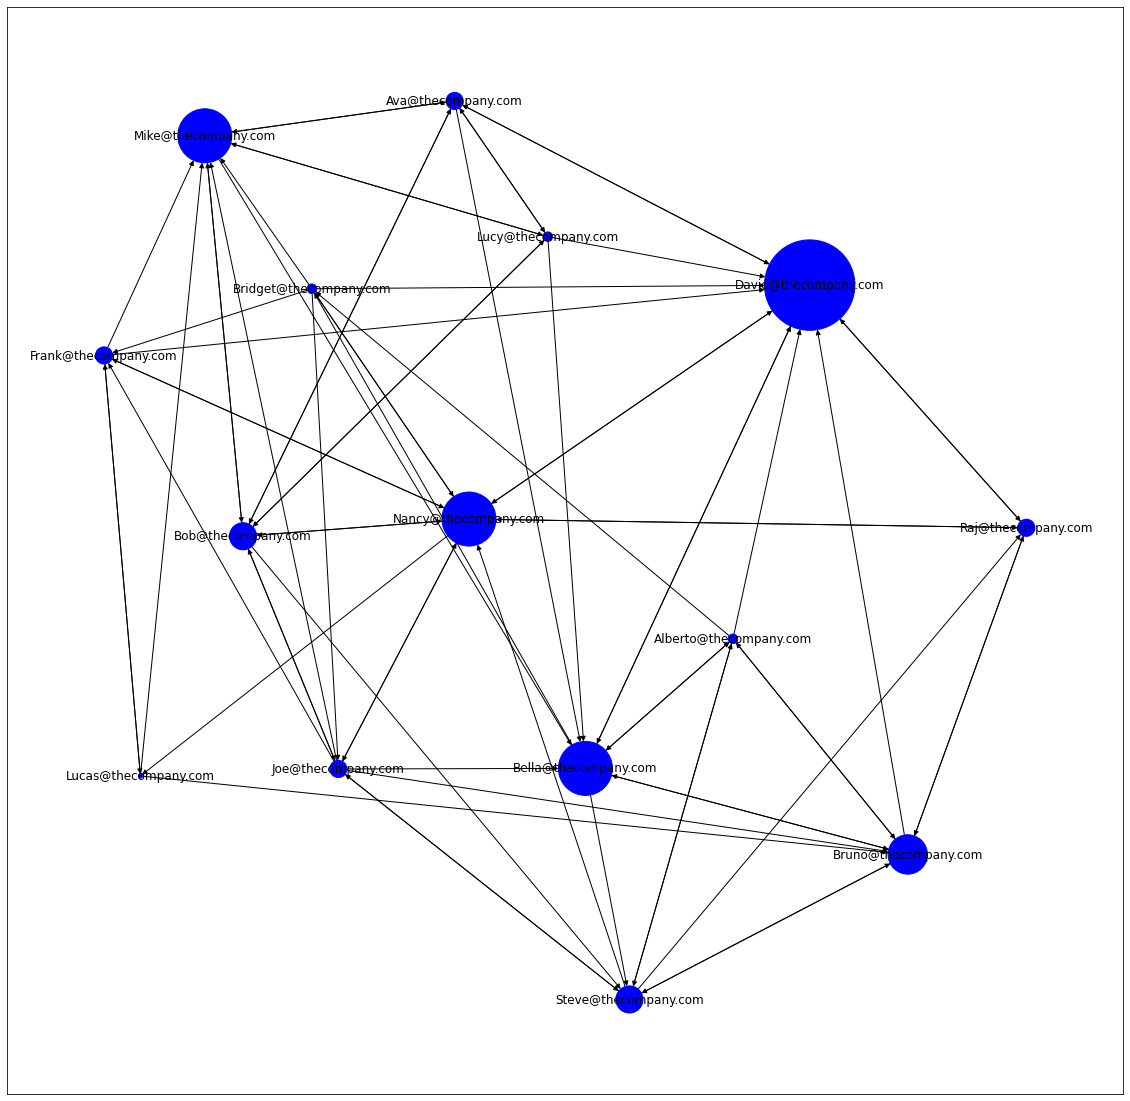

In [ ]:
d = dict(network_graph.in_degree()) # This is a new variable we will use to tell matplotlib how to size nodes

# Re-draw the graph
plt.figure(figsize=(20,20))
nx.draw_networkx(network_graph,
                 arrows=True,
                 node_color='b',
                 node_size= [v**4.1  for v in d.values()]) # This is a list comprehension
                                                           # It says for every value v in our new variable d, raise that value by the power of 4.1 

**Nice!**

Now our graph shows us who receives more or less connections based off the size of each node. 

Let's take this one step further by adding in department data.

In [ ]:
# We will need to make a 'color key' for networkx to work with
# The below code assigns a numeric code for each department which will then be used to assign color to each node
 
hris = hris.set_index('email')
hris = hris.reindex(network_graph.nodes())
hris['Department'] = pd.Categorical(hris['Department'])
hris['Department'].cat.codes

email
Alberto@thecompany.com    0
Bella@thecompany.com      0
Steve@thecompany.com      1
Bruno@thecompany.com      0
David@thecompany.com      3
Bridget@thecompany.com    3
Ava@thecompany.com        2
Lucy@thecompany.com       2
Mike@thecompany.com       2
Bob@thecompany.com        1
Joe@thecompany.com        1
Nancy@thecompany.com      1
Frank@thecompany.com      3
Raj@thecompany.com        3
Lucas@thecompany.com      3
dtype: int8

Let's recreate our graph once more.

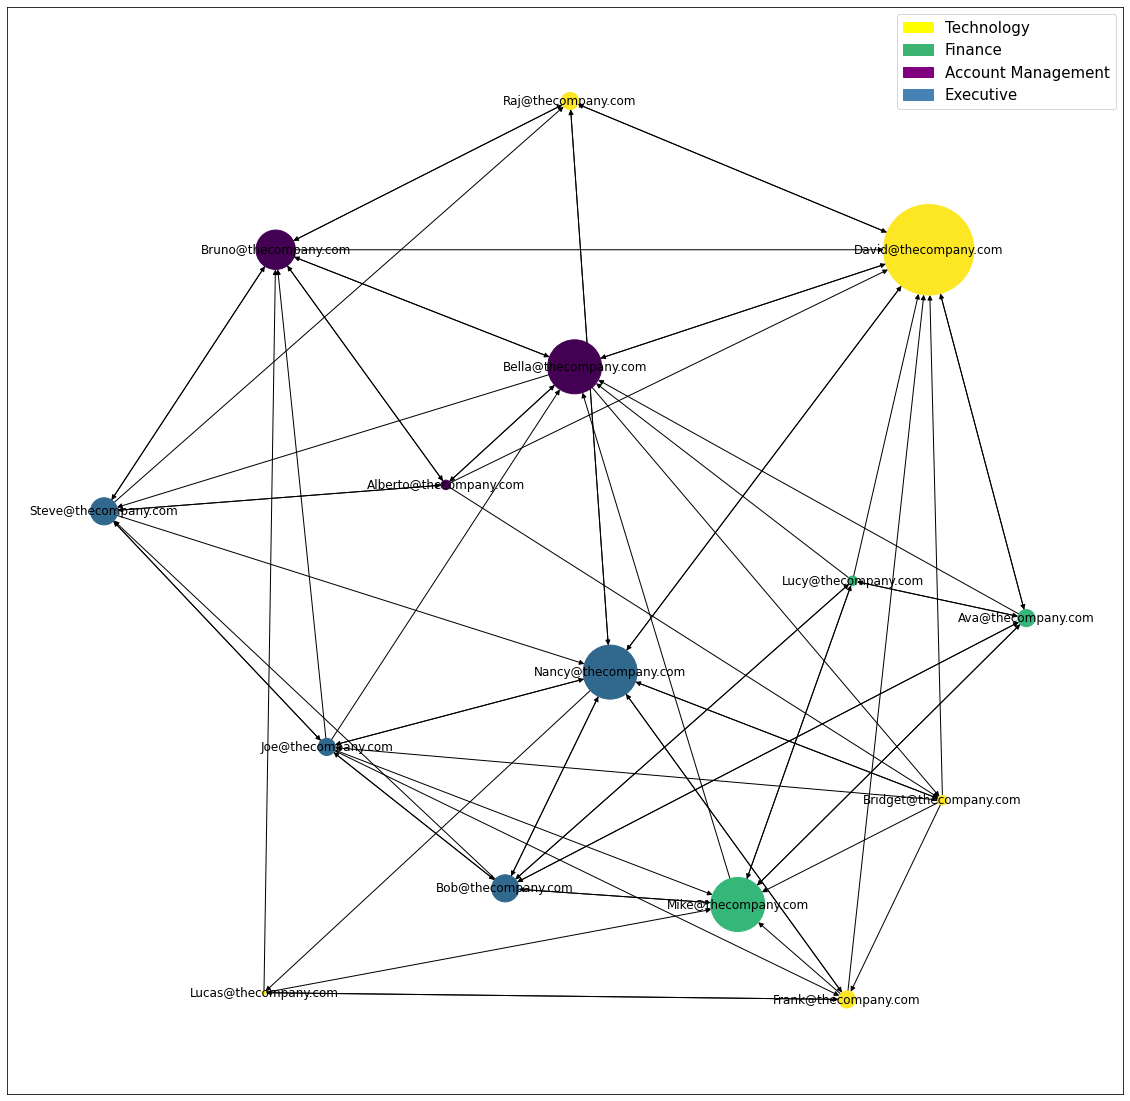

In [ ]:
plt.figure(figsize=(20,20))
nx.draw_networkx(network_graph,
                 arrows=True,
                 node_color=hris['Department'].cat.codes,
                 node_size= [v**4.1 for v in d.values()]) 

# We will use Patch and Line2D to create a legend of departments and their colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='yellow', edgecolor='yellow',label='Technology'),
                   Patch(facecolor='mediumseagreen', edgecolor='mediumseagreen',label='Finance'),
                   Patch(facecolor='purple', edgecolor='purple',label='Account Management'),
                   Patch(facecolor='steelblue', edgecolor='steelblue',label='Executive')]

plt.legend(handles=legend_elements,prop={'size': 15})

**Awesome!**

Here we can clearly see that David is the most sought out person at the company. If you recall, David is an IT Specialist. This may suggest a possible lack of resources in the Technology department.

##**Further Analysis**##

We can dig a bit further into our analysis by applying a few more transformations and calculations to our data set. This part isnt required, but I think they can be just as insightful as our network graph.

Let's start by displaying the number of *inbound connections* each person has.

In [ ]:
#For this, we'll use Pandas to count the number of times someone is named as important for anothers work

inbound_connections=pd.DataFrame(network_data.groupby('alter').size()) # Groupby will combine rows with the same email (participant) and size counts them

inbound_connections.reset_index(inplace=True)
inbound_connections.columns=['alter','Inbound Connections'] # We want to rename the count to something more intuitive 
inbound_connections.sort_values('Inbound Connections',ascending=False,inplace=True) # We can sort to see who is most influential on top

inbound_connections



,alter,Inbound Connections
6,David@thecompany.com,9
2,Bella@thecompany.com,7
11,Mike@thecompany.com,7
12,Nancy@thecompany.com,7
5,Bruno@thecompany.com,6
3,Bob@thecompany.com,5
14,Steve@thecompany.com,5
1,Ava@thecompany.com,4
7,Frank@thecompany.com,4
8,Joe@thecompany.com,4


Here, for each participant, we can see how many people seek them out. As you might notice, these counts are related to the size of each node in our graph.

It looks like David, Mike, Bella, and Nancy, are highly sought out employees.


### **Collaborative Overload**

__[Collaborative overload ](https://hbr.org/2016/01/collaborative-overload)__ is a measure we can use to assess burnout and turnover risk. It compares how frequently a person is sought out to how often someone else lists them as needing greater access. In my opinion, this is one of the most useful metrics ONA can produce.

Research by Rob Cross and Adam Grant at Connected Commons shows that when 25% or more of the colleagues seeking a particular person say they want greater access to them, that particular person may be suffering from collaborative overload.

Let's see who is overloaded.

In [ ]:
# First, We need to count the number of times someone said they needed greater access to someone else
#Since our "Greater access needed" variable is binary, we just need to sum these up for the alter

overload_count=pd.DataFrame(network_data.groupby('alter')['Greater access needed'].sum()) 

overload_count.reset_index(inplace=True)
overload_count.sort_values("Greater access needed",ascending=False,inplace=True)

overload_count

,alter,Greater access needed
11,Mike@thecompany.com,3.0
2,Bella@thecompany.com,2.0
6,David@thecompany.com,2.0
12,Nancy@thecompany.com,2.0
1,Ava@thecompany.com,1.0
3,Bob@thecompany.com,1.0
5,Bruno@thecompany.com,1.0
7,Frank@thecompany.com,1.0
8,Joe@thecompany.com,1.0
13,Raj@thecompany.com,1.0


In [ ]:
# Now, for each person in the network, we'll calculate the percent of people saying that they require greater access to that person

# First the inbound connection data will need to be merged to the greater access data

collaborative_overload=pd.merge(inbound_connections,overload_count,on='alter')

collaborative_overload['Percent requiring greater access']=100*collaborative_overload['Greater access needed']/collaborative_overload['Inbound Connections']

collaborative_overload.sort_values('Percent requiring greater access', ascending=False)

,alter,Inbound Connections,Greater access needed,Percent requiring greater access
2,Mike@thecompany.com,7,3.0,42.857143
1,Bella@thecompany.com,7,2.0,28.571429
3,Nancy@thecompany.com,7,2.0,28.571429
7,Ava@thecompany.com,4,1.0,25.000000
8,Frank@thecompany.com,4,1.0,25.000000
9,Joe@thecompany.com,4,1.0,25.000000
10,Raj@thecompany.com,4,1.0,25.000000
0,David@thecompany.com,9,2.0,22.222222
5,Bob@thecompany.com,5,1.0,20.000000
4,Bruno@thecompany.com,6,1.0,16.666667


In [ ]:
# Additionally, we can apply a filter to only display those that are high risk

high_risk_filter = collaborative_overload['Percent requiring greater access'] >= 25.00

high_risk_group = collaborative_overload[high_risk_filter].sort_values('Percent requiring greater access', ascending=False)

high_risk_group.head(10)

,alter,Inbound Connections,Greater access needed,Percent requiring greater access
2,Mike@thecompany.com,7,3.0,42.857143
1,Bella@thecompany.com,7,2.0,28.571429
3,Nancy@thecompany.com,7,2.0,28.571429
7,Ava@thecompany.com,4,1.0,25.000000
8,Frank@thecompany.com,4,1.0,25.000000
9,Joe@thecompany.com,4,1.0,25.000000
10,Raj@thecompany.com,4,1.0,25.000000


# **Conclusions:**

Mike is clearly highly influential/sought out and people arent getting enough of him. He may benefit from some coaching on how to delegate tasks and/or knowledge down to the two analysts on his team.

Bella is a fairly sought out as well. As a Jr. level employee she probably shouldnt have that much responsibility.

Overall, the company appears to have some issues with workload and potentially communication as well. Adding more headcount and a Learning and Development consultant may be a smart investment for the company.

# **Final Thoughts:**

If [Part I](https://www.kencav.io/o-networks-1/) of this series is what brought you here, I'm glad you saw it all the way through! I hope you have learned something valueble. If you like this kind of thing, you can [subscribe](https://www.kencav.io/signup/) to get updated when I post something new.